### Objective: To train and evaluate models for hydropbobicity on therapeutic antibodies. 

Previously, I calculated descriptors for hydrophobicity. I tried 3 different methods, 1. Mesh, 2. RSA, 3. SASA. I also tried multiple scales. It seems the best is the method is RSA, then the best scale is Ja. 

Here I am going to try modeling with different subsets of the data, as well as the different methods. 

I am also going to try ml_flow. 

In [1]:
import mlflow
from mlflow.models import infer_signature

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (mean_squared_error, r2_score, average_precision_score, roc_auc_score, accuracy_score, f1_score
                            ,precision_score, recall_score, confusion_matrix, classification_report, precision_recall_curve,
                            PredictionErrorDisplay)
                                
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, RepeatedKFold

from tqdm.notebook import tqdm


from developability.utils import ls
from developability.modeling import  plot_feature_importances, plot_regression_performance

#### get the data of interest and split into train and test sets and save it. 

In [2]:
base_path = Path("/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies")
data_path = base_path /"AbodyBuilder2_predicted_renumbered_stuctures"

In [3]:
files = [f for f in ls(base_path.parent) if f.name.endswith(".csv") and 'hydrophobicity_descriptors' in f.name]
sasa = pd.read_csv(base_path / "sasa_hydrophobicity_descriptors_12-11-2023.csv", index_col = 0).sort_index()
rsa = pd.read_csv(base_path / "sasa_hydrophobicity_descriptors_12-11-2023.csv", index_col=0).sort_index()
mesh = pd.read_csv(base_path /'hydrophobicity_scales_scan_results_12-01-2023.csv', index_col = 0).sort_index()


invitro_df = pd.read_csv(base_path/'invitro_measurments_from_tushar_2023.csv')
invitro_df = invitro_df.set_index('Name')
hic = invitro_df['HIC'].sort_index()

In [4]:
mesh = mesh.merge(hic, left_index=True, right_index=True)
rsa=rsa.merge(hic, left_index=True, right_index=True)
sasa = sasa.merge(hic, left_index=True, right_index=True)

/var/folders/8n/vvdlr4dj1gg4gwyb3s3bmj2c0000gp/T/ipykernel_27452/4126505390.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(hic, bins = 25)
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf v

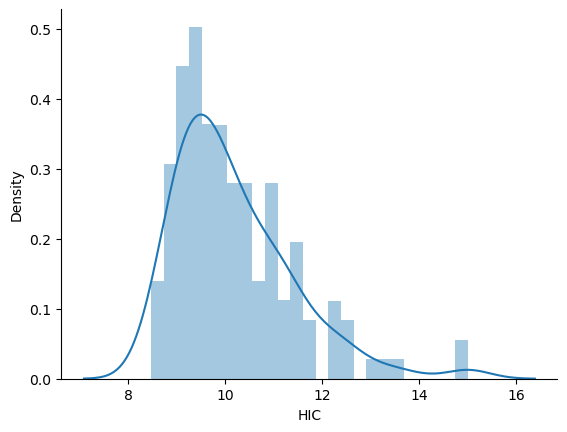

In [5]:
ax = sns.distplot(hic, bins = 25)
sns.despine();

In [6]:
hic.sort_values()

Name
dacetuzumab       8.47
denosumab         8.50
efalizumab        8.67
tovetumab         8.67
lenzilumab        8.72
                 ...  
enokizumab       12.93
atezolizumab     13.35
glembatumumab    13.68
lirilumab        15.00
nimotuzumab      15.00
Name: HIC, Length: 137, dtype: float64

In [7]:
def partition_data(df,scale, test_size = 0.2, seed = 22, method='sasa', save_path=None):
    """Split data into train and test sets"""
   
    df = df.copy()

    if 'radius' in df.columns:
        df = df.query(f"radius == {1} and scale == '{scale}'")
    else:
        df = df.query(f"scale == '{scale}'")

    
    train, test = train_test_split(df, test_size = test_size, random_state = seed)

    train['dataset'] = 'train'
    test['dataset'] = 'test'

    train_test = pd.concat([train, test])
    
    if save_path: 
        if not save_path.exists(): save_path.mkdir()
        train_test.to_parquet(save_path/f"{method}_{scale}_train_test.parquet")

    return train_test

In [8]:
save_path = data_path/'model_data'

dfs = [mesh,rsa,sasa]
methods = ['mesh','rsa','sasa']
scales = ['Ja','WiWh', 'BlMo']

for df, method in tqdm(zip(dfs, methods), total = 3):
    for scale in scales:
        train_test = partition_data(df,scale = scale, test_size = 0.2, seed = 32, method=method, save_path=save_path)
        print(f"Saved {method}_{scale}_train_test.parquet")


  0%|          | 0/3 [00:00<?, ?it/s]

Saved mesh_Ja_train_test.parquet
Saved mesh_WiWh_train_test.parquet
Saved mesh_BlMo_train_test.parquet
Saved rsa_Ja_train_test.parquet
Saved rsa_WiWh_train_test.parquet
Saved rsa_BlMo_train_test.parquet
Saved sasa_Ja_train_test.parquet
Saved sasa_WiWh_train_test.parquet
Saved sasa_BlMo_train_test.parquet


In [9]:
train= train_test.query("dataset == 'train'")
test = train_test.query("dataset == 'test'")

/var/folders/8n/vvdlr4dj1gg4gwyb3s3bmj2c0000gp/T/ipykernel_27452/719534178.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['HIC'])
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to

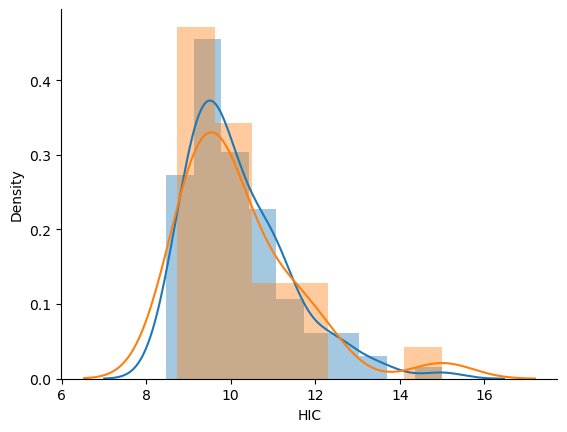

In [10]:
sns.distplot(train['HIC'])
sns.distplot(test['HIC'])
sns.despine();

In [11]:
pos_cols = [col for col in train.columns if 'pos' in col and ('1' in col or '2' in col or '3' in col or '4' in col)]
total_pos_cols = [col for col in train.columns if 'pos' in col and not ('1' in col or '2' in col or '3' in col or '4' in col)]  

In [12]:
def load_data(method, scale, save_path,cols = None, dataset='train'):
    """Load data from disk"""

    df = pd.read_parquet(save_path/f"{method}_{scale}_train_test.parquet")
    df =df.query("dataset == @dataset")
    
    if cols:
        X = df[cols]
    else:
        X = df.drop(['HIC','dataset'], axis = 1)
    y = df['HIC']
    return X, y
    

In [13]:
def round_dataframe(df, decimals=3):
    """Round all values in dataframe to specified number of decimals"""
    for col in df.columns:
        if df[col].dtype == int or df[col].dtype == float:
            df[col] = df[col].round(decimals)

    return df


def extract_train_test_cv_scores(grid, score_name=None, decimals=3):
    """Extract train and test scores from gridsearchcv object and returns a dictionary of scores with keys having name of score and value being the score
    Args:
        grid: GridSearchCV object
        score_name: Name of score to extract. If None, all scores are extracted 
        decimals: Number of decimals to round scores to
    Returns:
        scores: Dictionary of scores with keys having name of score and value being the score
    
    
    """

    scores_df = (pd.DataFrame(grid.cv_results_)
                .sort_values('rank_test_score')
                .head(1)
                )
    scores_df = round_dataframe(scores_df, decimals=decimals)
    
    if not score_name:
        score_name = 'scores'

    scores = {f'CV_train_{score_name}_mean': scores_df['mean_train_score'].values[0],
                f'CV_train_{score_name}_std': scores_df['std_train_score'].values[0],
                f'CV_test_{score_name}_mean': scores_df['mean_test_score'].values[0],
                f'CV_test_{score_name}_std': scores_df['std_test_score'].values[0],
                f'CV_test_{score_name}_rank': scores_df['rank_test_score'].values[0]}
    return scores


def train_gridsearch_mlflow(model, params, method, scale, cols, scoring, cv=None, regression=True, test_size=0.2):
    """Train model with gridsearch and log results to mlflow"""        

    if not cv:
        cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=32)


    if isinstance(model, Pipeline):
        model_name = model.steps[-1][1].__class__.__name__
    else:
        model_name = model.__class__.__name__

    with mlflow.start_run():
        mlflow.set_tag('method', method)
        mlflow.set_tag('scale', scale)
        mlflow.set_tag('model', model_name)
        mlflow.set_tag('cols', ', '.join(cols))
        mlflow.set_tag('scoring', scoring)
        #mlflow.set_tag('cv', cv)


        X,y = load_data(method, scale, save_path, cols=cols, dataset='train')
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=32)
        
        grid = GridSearchCV(model, params, scoring=scoring, cv=cv, 
                            n_jobs=-1, refit=True, verbose=1, return_train_score=True)
    
        grid.fit(X_train, y_train)

        y_pred = grid.predict(X_val)

        #log results to mlflow
    
        try: 
            fig,_ =plot_feature_importances(grid.best_estimator_, model_name=model_name)
            mlflow.log_figure(fig, 'feature_importances.png')
        except:
            pass
        
        if regression: 
            mlflow.log_metrics({'val_mse': mean_squared_error(y_val, y_pred),
                                'val_r2': r2_score(y_val, y_pred)})
            
            scores = extract_train_test_cv_scores(grid, score_name='rmse')
            mlflow.log_metrics(scores)
            fig,_= plot_regression_performance(grid, X_val, y_val, model_name=model_name)
            mlflow.log_figure(fig, 'prediction_error.png')


        else:
            mlflow.log_metrics({'roc_auc': roc_auc_score(y_val, y_pred), # 'roc_auc' for binary classification,
                                'precision_recall': average_precision_score(y_val, y_pred), # 'precision_recall' for binary classification
                                'accuracy': accuracy_score(y_val, y_pred),
                                'f1': f1_score(y_val, y_pred)})
        
        mlflow.log_params(grid.best_params_)
        try:
            mlflow.log_params(grid.cv_results_)
        except:
            pass

        signature = infer_signature(X_train, y_train)
        mlflow.sklearn.log_model(grid.best_estimator_, 'model', signature=signature)
        
        return grid.best_estimator_, grid.best_params_, grid.best_score_

In [14]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# Create a new MLflow Experiment
mlflow.set_experiment("HydrophobicityExperiments1")

2023/12/14 14:24:00 INFO mlflow.tracking.fluent: Experiment with name 'HydrophobicityExperiments1' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/135591394731012091', creation_time=1702592640968, experiment_id='135591394731012091', last_update_time=1702592640968, lifecycle_stage='active', name='HydrophobicityExperiments1', tags={}>

#### Train Ridge 

  0%|          | 0/3 [00:00<?, ?it/s]

Fitting 15 folds for each of 7 candidates, totalling 105 fits
Best score for mesh_Ja is -1.3656716194980636
Fitting 15 folds for each of 7 candidates, totalling 105 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best score for mesh_WiWh is -1.4047064867518513
Fitting 15 folds for each of 7 candidates, totalling 105 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best score for mesh_BlMo is -1.3840795260792016
Fitting 15 folds for each of 7 candidates, totalling 105 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best score for rsa_Ja is -1.4164740926325328
Fitting 15 folds for each of 7 candidates, totalling 105 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best score for rsa_WiWh is -1.4173444756222435
Fitting 15 folds for each of 7 candidates, totalling 105 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best score for rsa_BlMo is -1.3956692681479306
Fitting 15 folds for each of 7 candidates, totalling 105 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best score for sasa_Ja is -1.4164740926325328
Fitting 15 folds for each of 7 candidates, totalling 105 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best score for sasa_WiWh is -1.4173444756222435
Fitting 15 folds for each of 7 candidates, totalling 105 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best score for sasa_BlMo is -1.3956692681479306


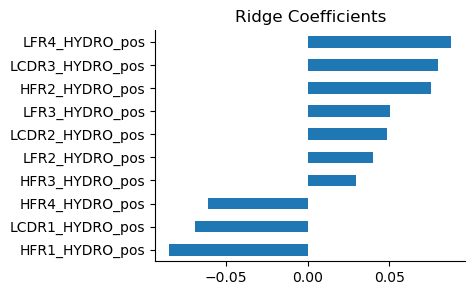

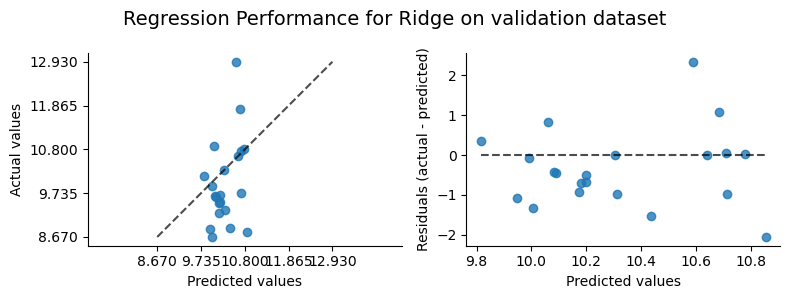

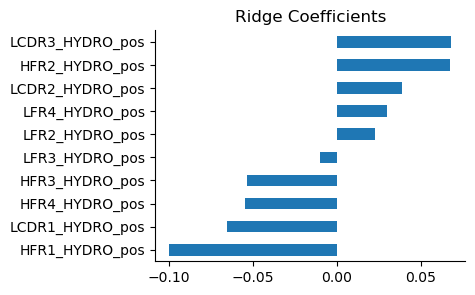

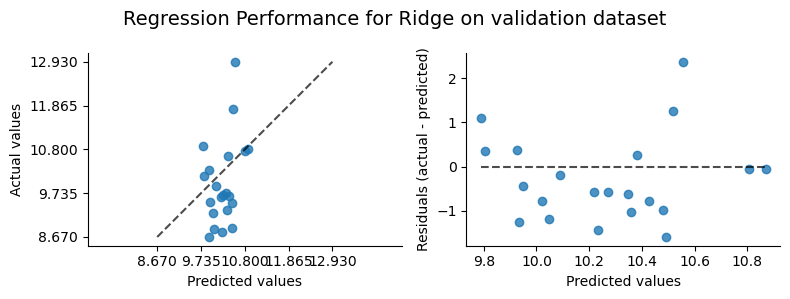

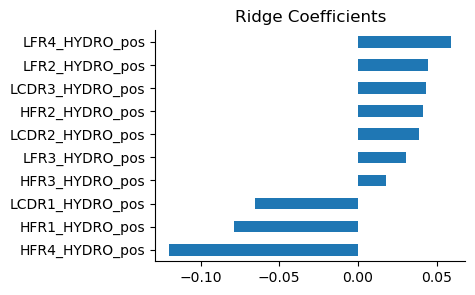

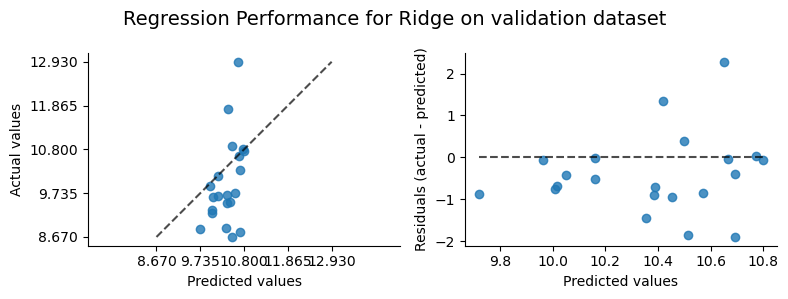

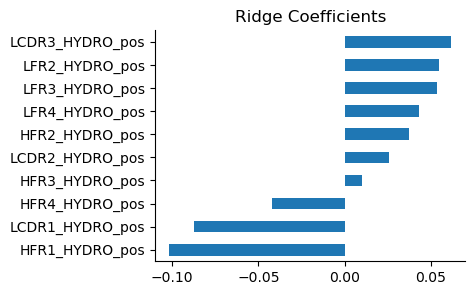

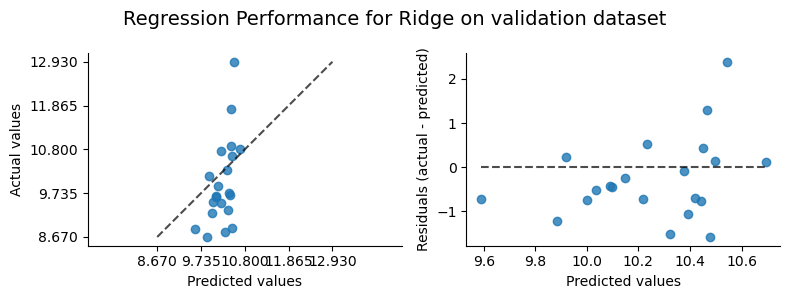

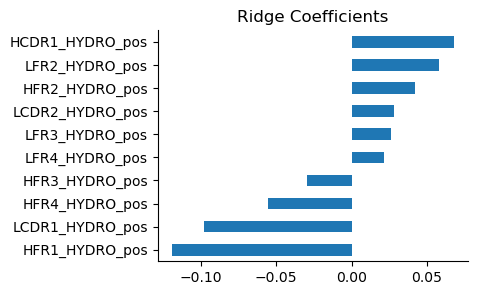

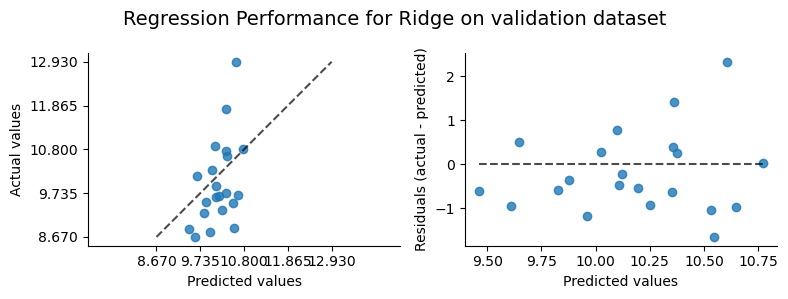

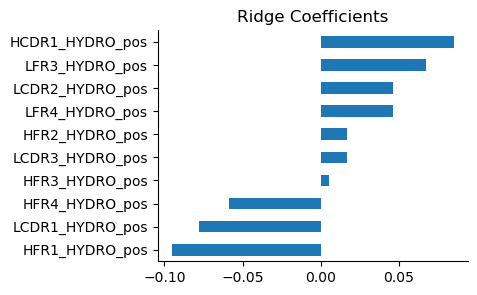

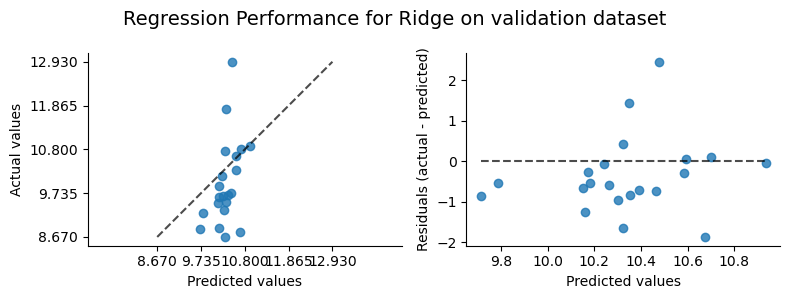

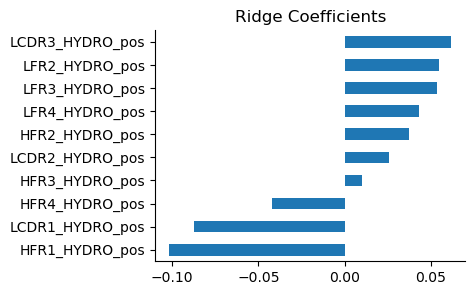

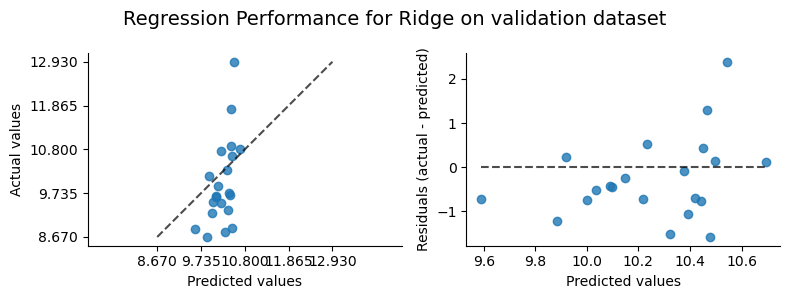

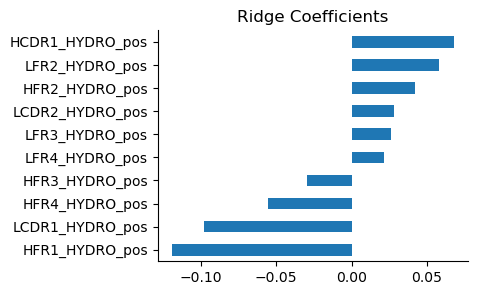

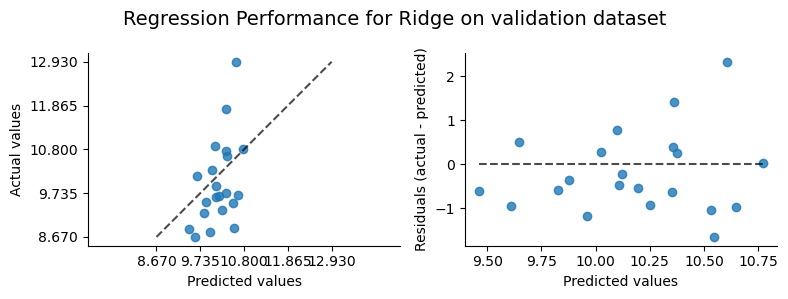

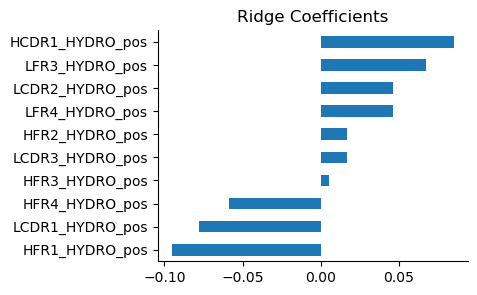

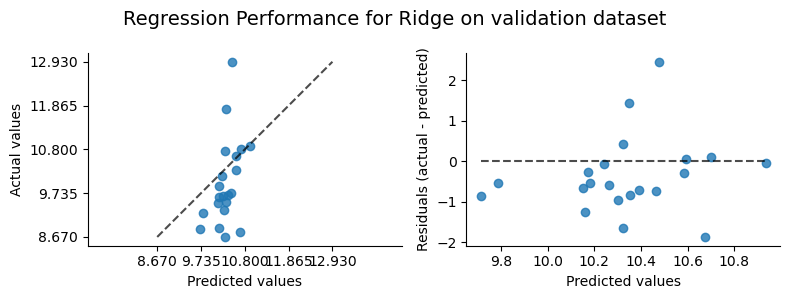

In [15]:
cols = pos_cols
l2_ridge = Ridge()
scaler = StandardScaler()
pipe = Pipeline([('scaler', scaler), ('ridge', l2_ridge)])
l2_ridge_params = {'ridge__alpha': np.logspace(-3, 3, 7)}


for method in tqdm(methods):
    for scale in scales:
        model, params, score = train_gridsearch_mlflow(pipe, l2_ridge_params, method, scale, cols, scoring='neg_mean_squared_error')
        print(f"Best score for {method}_{scale} is {score}")

### Train Lasso Regression

  0%|          | 0/3 [00:00<?, ?it/s]

Fitting 15 folds for each of 7 candidates, totalling 105 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best score for mesh_Ja is -1.4877206979120732
Fitting 15 folds for each of 7 candidates, totalling 105 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best score for mesh_WiWh is -1.4630513003274774
Fitting 15 folds for each of 7 candidates, totalling 105 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best score for mesh_BlMo is -1.382257664758895
Fitting 15 folds for each of 7 candidates, totalling 105 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best score for rsa_Ja is -1.4379658721577286
Fitting 15 folds for each of 7 candidates, totalling 105 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best score for rsa_WiWh is -1.487602151723037
Fitting 15 folds for each of 7 candidates, totalling 105 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best score for rsa_BlMo is -1.3518562222973354
Fitting 15 folds for each of 7 candidates, totalling 105 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best score for sasa_Ja is -1.4379658721577286
Fitting 15 folds for each of 7 candidates, totalling 105 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best score for sasa_WiWh is -1.487602151723037
Fitting 15 folds for each of 7 candidates, totalling 105 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best score for sasa_BlMo is -1.3518562222973354


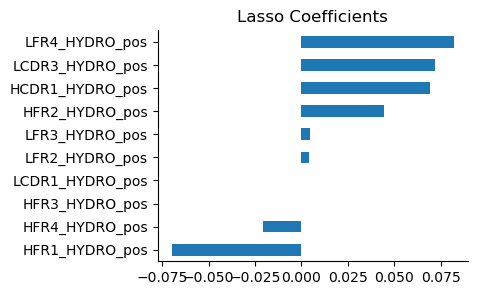

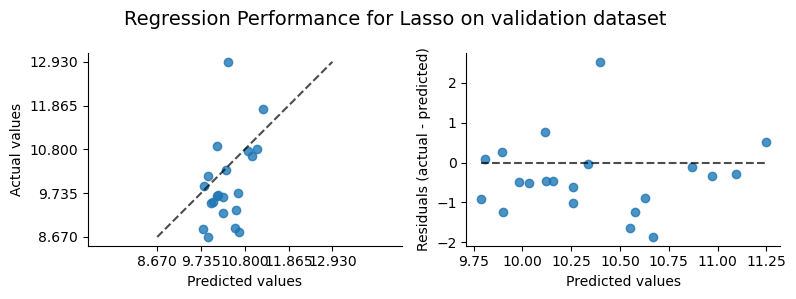

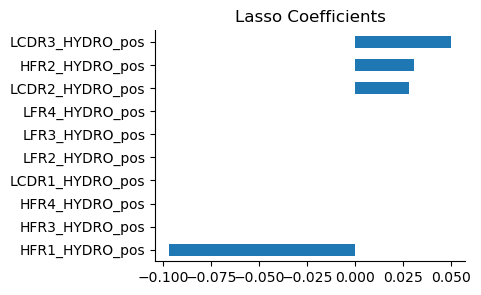

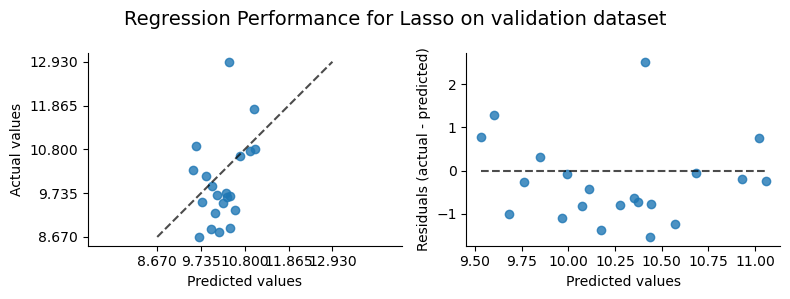

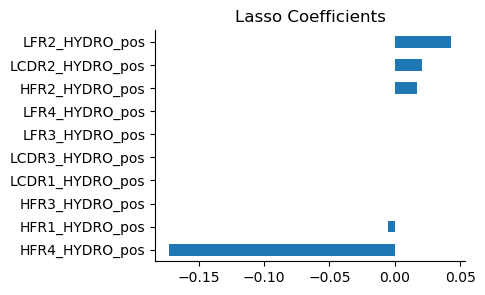

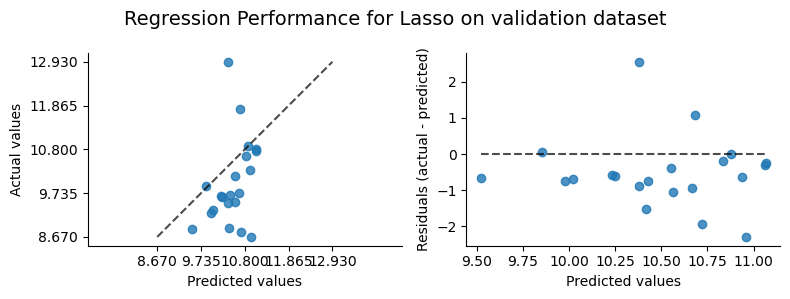

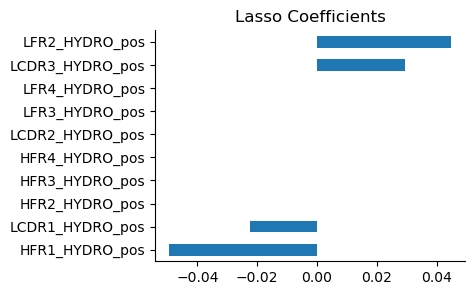

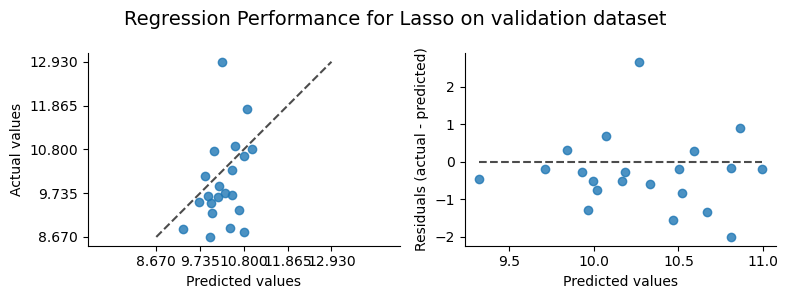

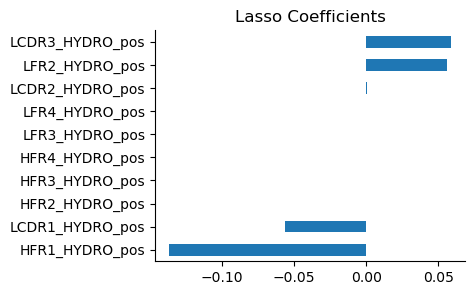

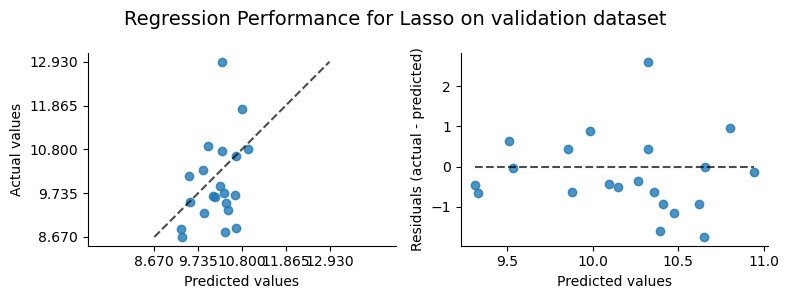

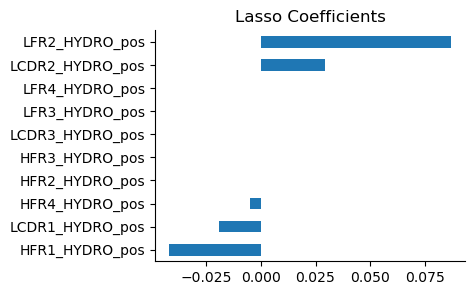

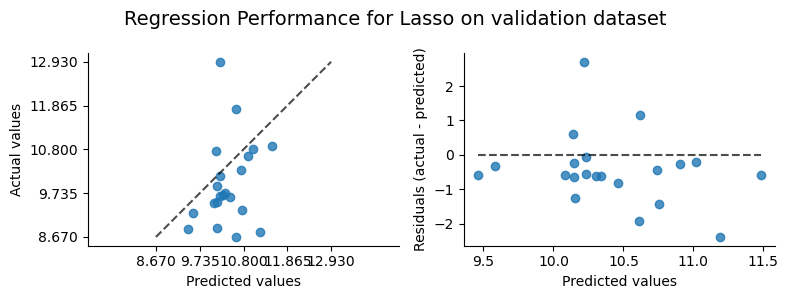

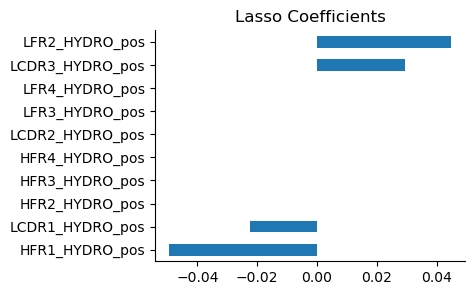

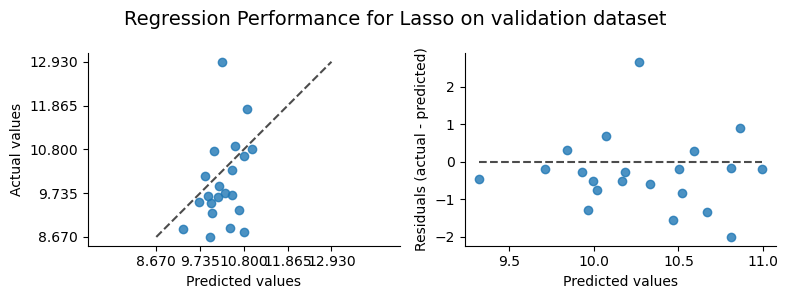

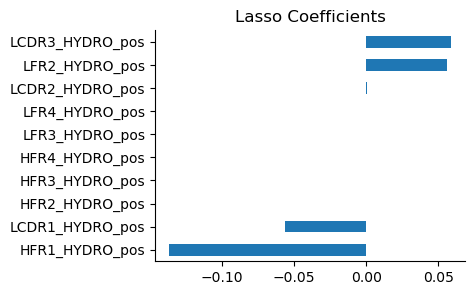

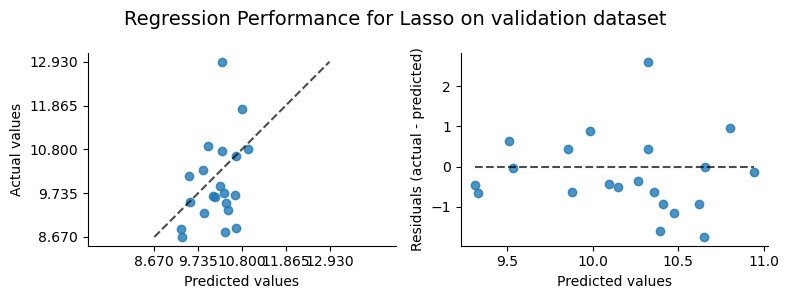

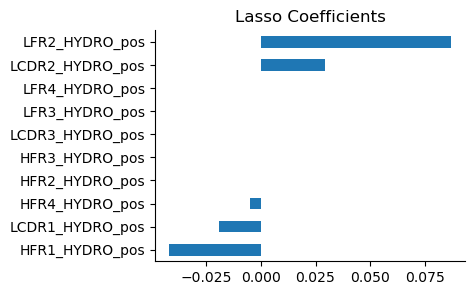

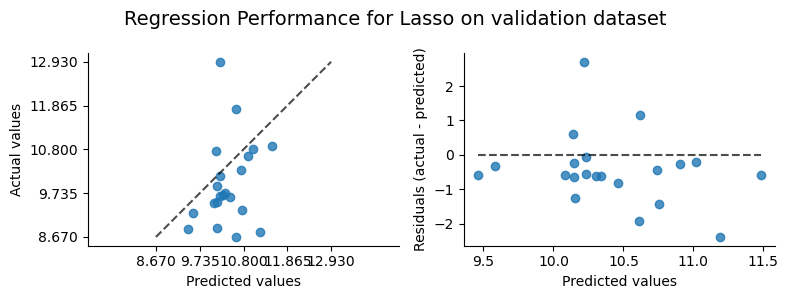

In [16]:
cols = pos_cols
lasso = Lasso()
scaler = StandardScaler()
pipe = Pipeline([('scaler', scaler), ('lasso', lasso)])
lasso_params = {'lasso__alpha': np.logspace(-3, 3, 7)}


for method in tqdm(methods):
    for scale in scales:
        model, params, score = train_gridsearch_mlflow(pipe, lasso_params, method, scale, cols, scoring='neg_mean_squared_error')
        print(f"Best score for {method}_{scale} is {score}")

### Train ElasticNet

  0%|          | 0/3 [00:00<?, ?it/s]

Fitting 15 folds for each of 35 candidates, totalling 525 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.765e+01, tolerance: 1.121e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.569e+01, tolerance: 9.652e-03 Linear regression models with null weight for the l1 regularization term are more ef

Best score for mesh_Ja is -1.3488047108499293
Fitting 15 folds for each of 35 candidates, totalling 525 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.484e+01, tolerance: 1.100e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.281e+01, tolerance: 1.121e-02 Linear regression models with null weight for the l1 regularization term are more ef

Best score for mesh_WiWh is -1.3904660295773512
Fitting 15 folds for each of 35 candidates, totalling 525 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.948e+01, tolerance: 1.115e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.355e+01, tolerance: 1.175e-02 Linear regression models with null weight for the l1 regularization term are more ef

Best score for mesh_BlMo is -1.3671099427784965
Fitting 15 folds for each of 35 candidates, totalling 525 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.360e+01, tolerance: 7.740e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.679e+01, tolerance: 7.822e-03 Linear regression models with null weight for the l1 regularization term are more ef

Best score for rsa_Ja is -1.4069540628214265
Fitting 15 folds for each of 35 candidates, totalling 525 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.348e+01, tolerance: 1.175e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.245e+01, tolerance: 1.099e-02 Linear regression models with null weight for the l1 regularization term are more ef

Best score for rsa_WiWh is -1.4092582627824524
Fitting 15 folds for each of 35 candidates, totalling 525 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.793e+01, tolerance: 9.652e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.417e+01, tolerance: 1.191e-02 Linear regression models with null weight for the l1 regularization term are more ef

Best score for rsa_BlMo is -1.3518562222973354
Fitting 15 folds for each of 35 candidates, totalling 525 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.831e+01, tolerance: 9.652e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.714e+01, tolerance: 1.017e-02 Linear regression models with null weight for the l1 regularization term are more ef

Best score for sasa_Ja is -1.4069540628214265
Fitting 15 folds for each of 35 candidates, totalling 525 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.785e+01, tolerance: 9.652e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.416e+01, tolerance: 1.191e-02 Linear regression models with null weight for the l1 regularization term are more ef

Best score for sasa_WiWh is -1.4092582627824524
Fitting 15 folds for each of 35 candidates, totalling 525 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.180e+01, tolerance: 1.065e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.115e+01, tolerance: 1.112e-02 Linear regression models with null weight for the l1 regularization term are more ef

Best score for sasa_BlMo is -1.3518562222973354


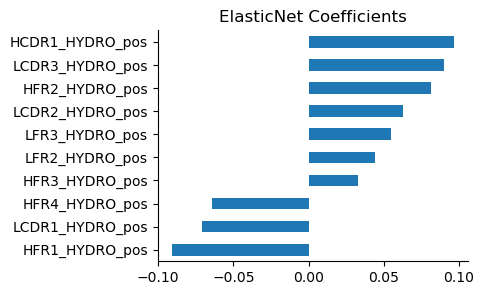

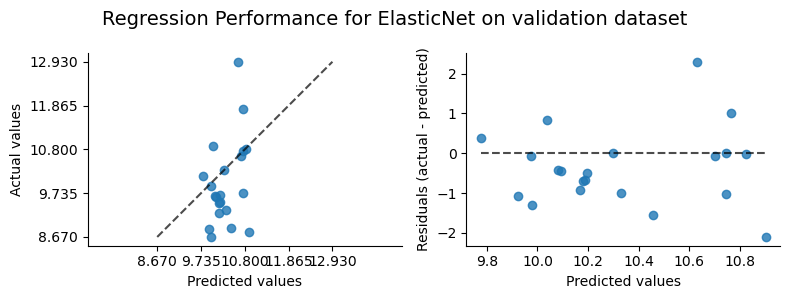

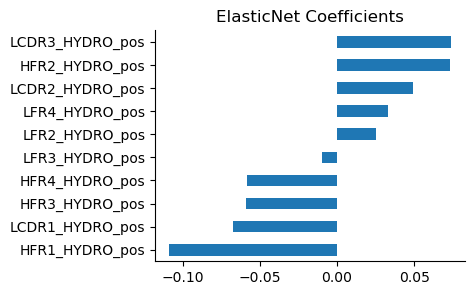

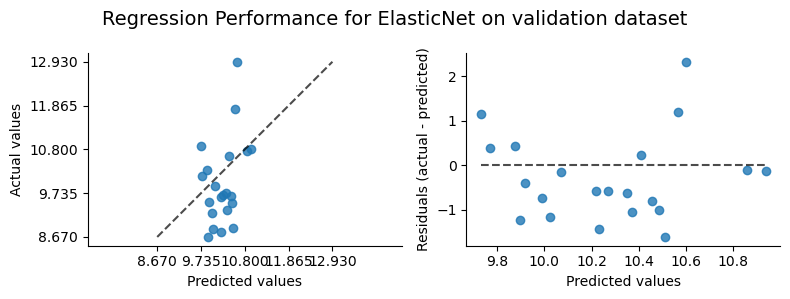

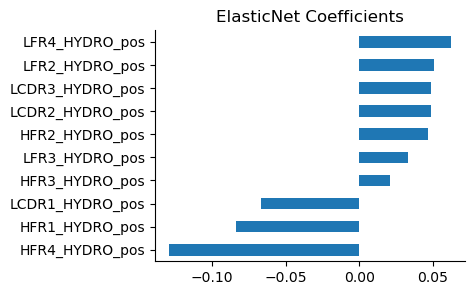

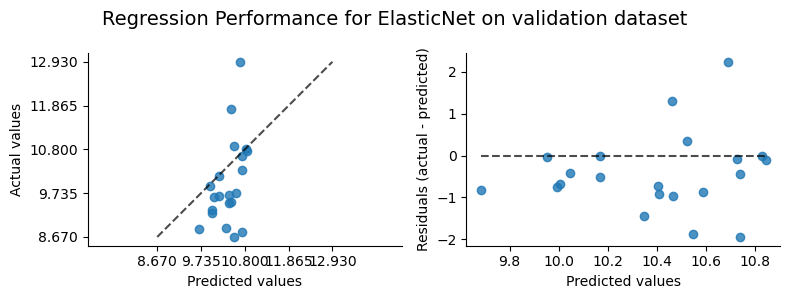

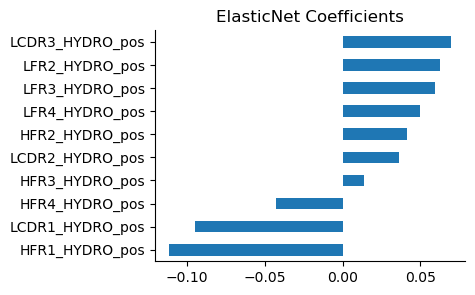

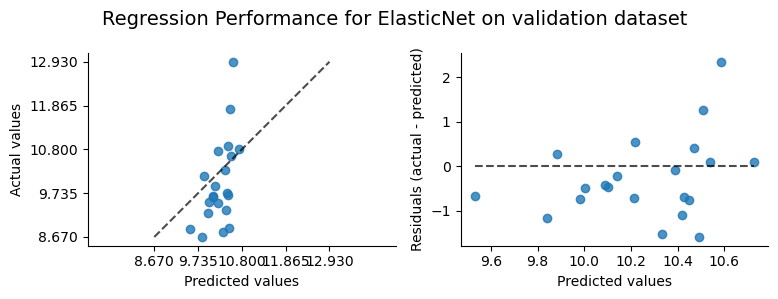

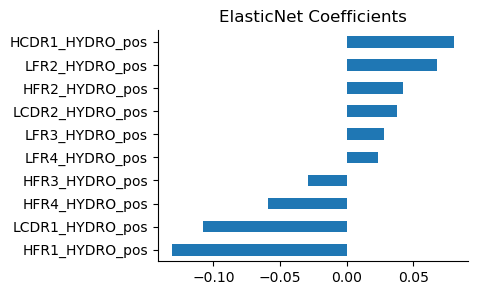

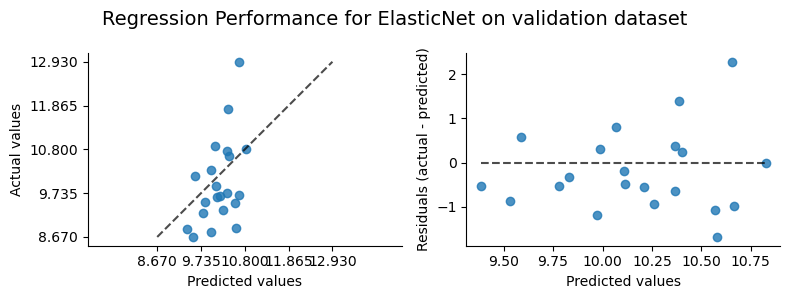

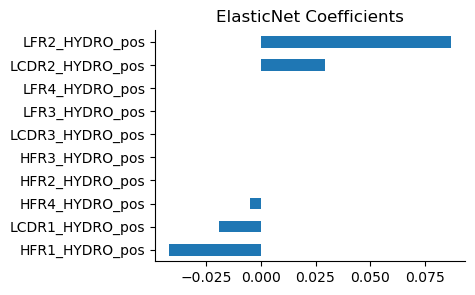

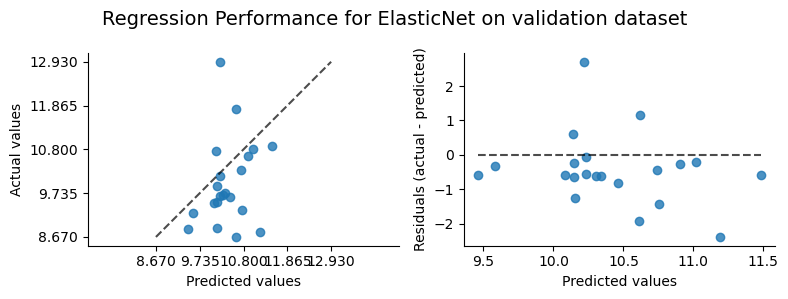

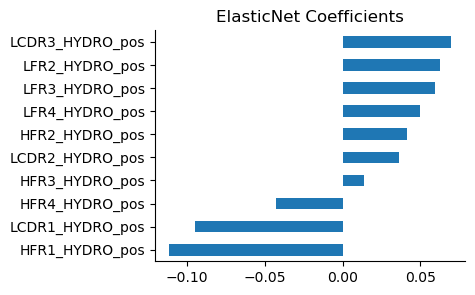

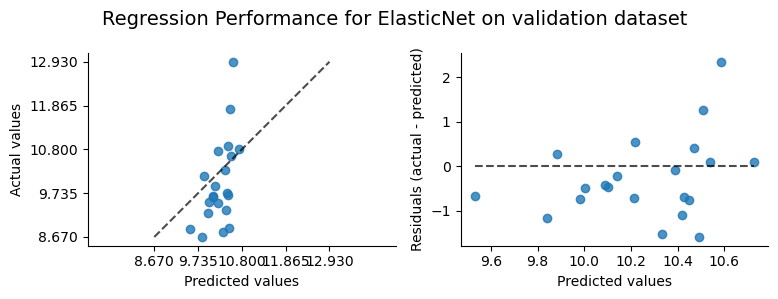

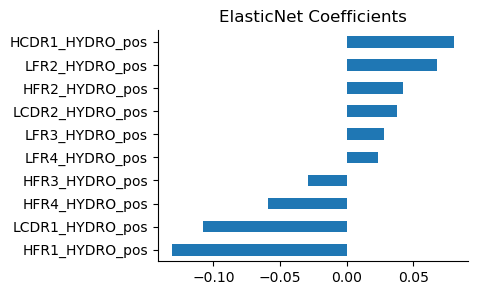

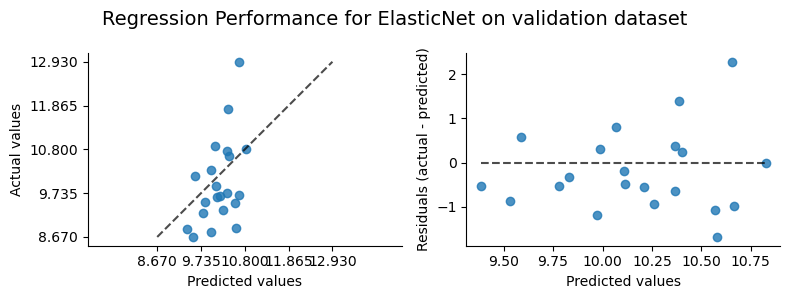

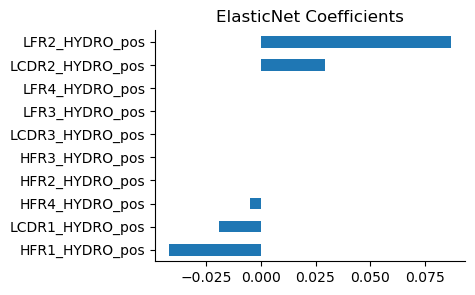

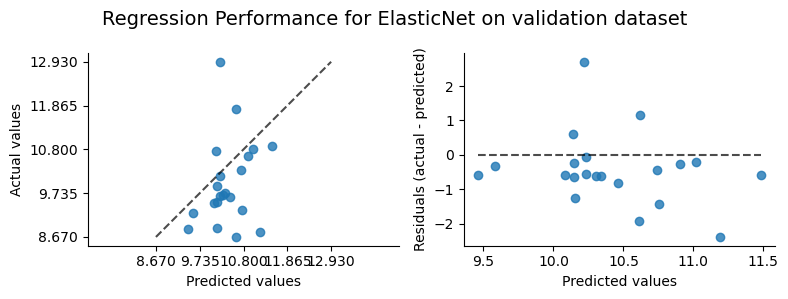

In [17]:
# train elastic net
cols = pos_cols
elastic_net = ElasticNet()
scaler = StandardScaler()
pipe = Pipeline([('scaler', scaler), ('elastic_net', elastic_net)])
elastic_net_params = {'elastic_net__alpha': np.logspace(-3, 3, 7),
                      'elastic_net__l1_ratio': np.linspace(0,1,5)}

for method in tqdm(methods):
    for scale in scales:
        model, params, score = train_gridsearch_mlflow(pipe, elastic_net_params, method, scale, cols, scoring='neg_mean_squared_error')
        print(f"Best score for {method}_{scale} is {score}")

### Train Random Forest

  0%|          | 0/3 [00:00<?, ?it/s]

Fitting 15 folds for each of 105 candidates, totalling 1575 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best score for mesh_Ja is -1.2575253503054542
Fitting 15 folds for each of 105 candidates, totalling 1575 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best score for mesh_WiWh is -1.3296259636684715
Fitting 15 folds for each of 105 candidates, totalling 1575 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best score for mesh_BlMo is -1.2706914437582075
Fitting 15 folds for each of 105 candidates, totalling 1575 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best score for rsa_Ja is -1.3655594688218609
Fitting 15 folds for each of 105 candidates, totalling 1575 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best score for rsa_WiWh is -1.3151129424261574
Fitting 15 folds for each of 105 candidates, totalling 1575 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best score for rsa_BlMo is -1.3745785486396584
Fitting 15 folds for each of 105 candidates, totalling 1575 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best score for sasa_Ja is -1.3655594688218609
Fitting 15 folds for each of 105 candidates, totalling 1575 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best score for sasa_WiWh is -1.3151129424261574
Fitting 15 folds for each of 105 candidates, totalling 1575 fits


/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best score for sasa_BlMo is -1.3745785486396584


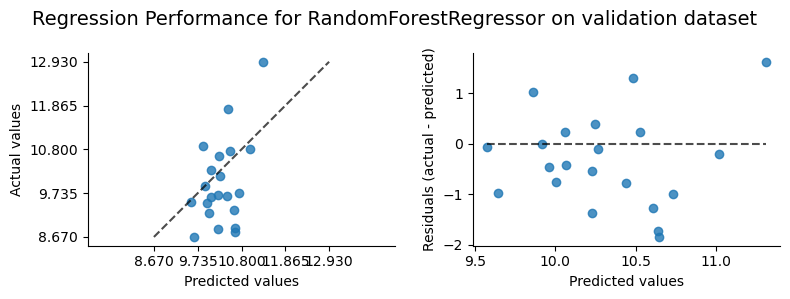

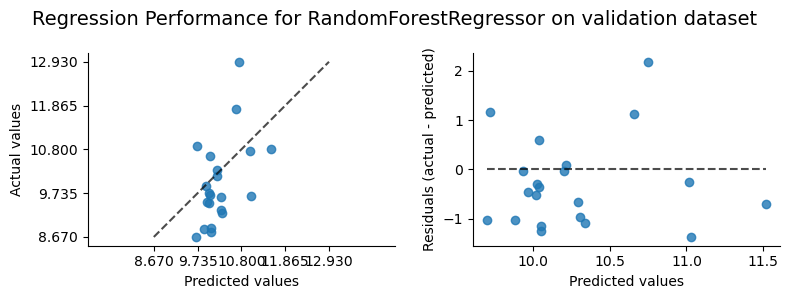

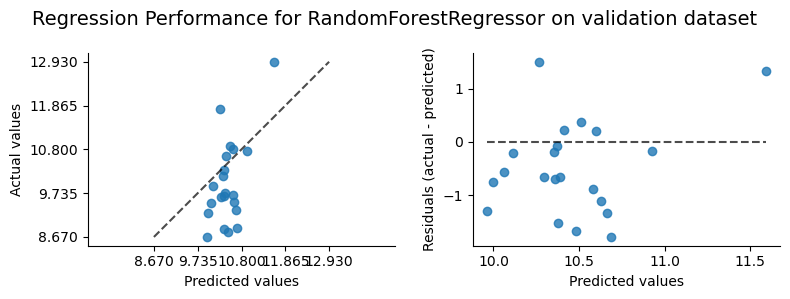

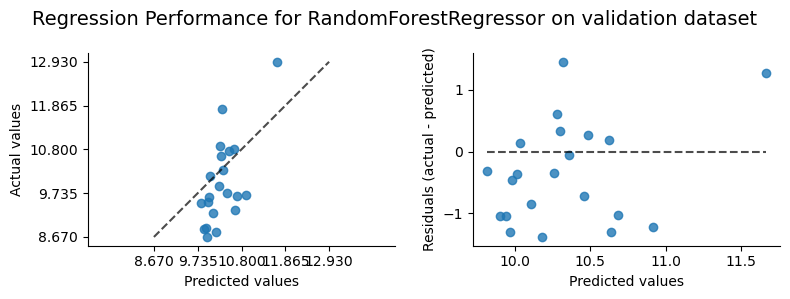

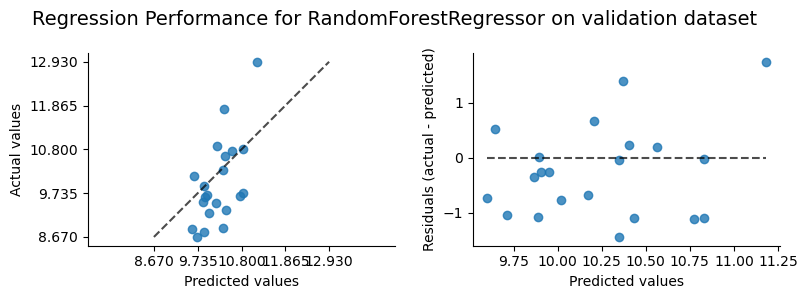

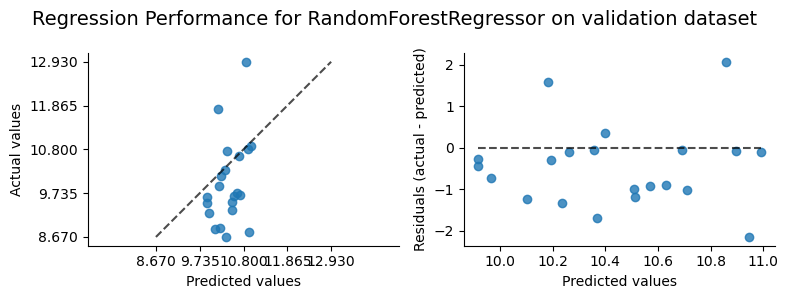

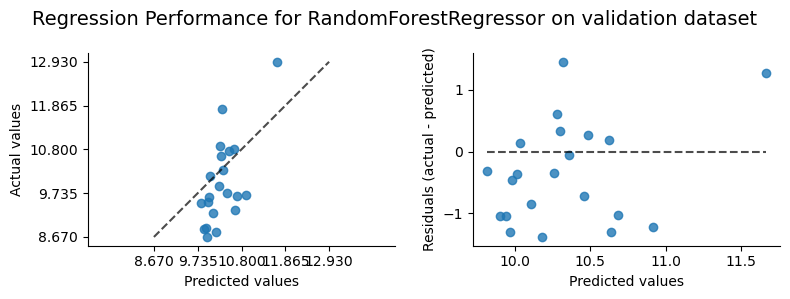

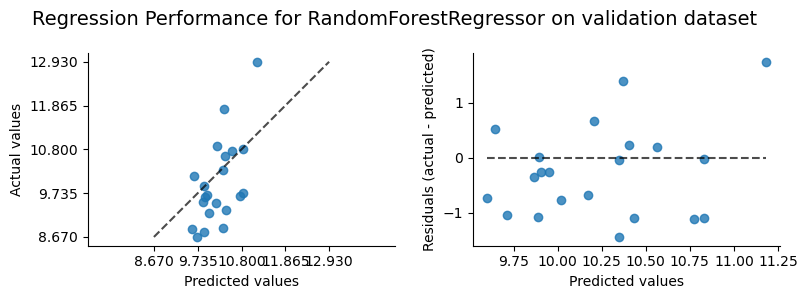

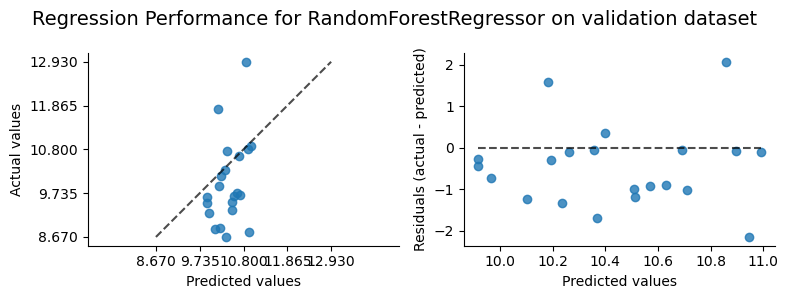

In [18]:
### train random forest regressor as above
cols = pos_cols
rf = RandomForestRegressor(random_state=32, oob_score=True)

rf_params = {'n_estimators': [100, 200, 300, 400, 500], 
             'max_depth': [3, 4, 5, 6, 7, 8, 9],
             'max_features': [1.0, 'sqrt', 'log2']}

for method in tqdm(methods):
    for scale in scales:
        model, params, score = train_gridsearch_mlflow(rf, rf_params, method, scale, cols, scoring='neg_mean_squared_error')
        print(f"Best score for {method}_{scale} is {score}")
